In [57]:
# pip install pymongo numpy matplotlib  (需要可视化时)
from pymongo import MongoClient
import numpy as np
from scipy.signal import savgol_filter

In [73]:
def estimate_sigma(q, I, lowq_frac=0.2, win_frac=0.06, poly=2,
                          n_bins=25, rN=0.0, floor_scale=1.0, monotone=True):
    q = np.asarray(q, float); I = np.asarray(I, float)
    m = np.isfinite(q) & np.isfinite(I) & (q > 0)
    q, I = q[m], I[m]
    order = np.argsort(q); q, I = q[order], I[order]
    n = len(q); logq = np.log(q)

    # 等距 log q 重采样 + SavGol 平滑作为趋势
    logq_u = np.linspace(logq[0], logq[-1], n)
    Iu = np.interp(logq_u, logq, I)
    win = max(5, int(n*win_frac) | 1)
    trend = savgol_filter(Iu, win, poly)
    resid = Iu - trend

    # 低-q 残差标定 s * sqrt(I)
    cut = np.quantile(logq_u, lowq_frac)
    low = logq_u <= cut
    mad = np.median(np.abs(resid[low] - np.median(resid[low])))
    sigma_ref = 1.4826 * mad
    msqrt = np.median(np.sqrt(np.clip(Iu[low], 0, None)) + 1e-16)
    s = 0.0 if msqrt == 0 else sigma_ref / msqrt

    # 局部加性地板：分箱 MAD -> std，并可强制随 q 非减
    edges = np.linspace(0, n, n_bins + 1, dtype=int)
    centers, floor = [], []
    for b in range(n_bins):
        seg = resid[edges[b]:edges[b+1]]
        med = np.median(seg); mad = np.median(np.abs(seg - med))
        floor.append(1.4826 * mad)
        centers.append(np.median(logq_u[edges[b]:edges[b+1]]))
    floor = np.array(floor) * floor_scale
    if monotone: floor = np.maximum.accumulate(floor)
    floor_u = np.interp(logq_u, np.array(centers), floor)

    # 合成误差并映射回原网格
    Ipos = np.clip(I, 0, None)
    sigma = np.sqrt((s * np.sqrt(Ipos))**2 + floor_u**2 + (rN * I)**2)
    inv = np.empty_like(order); inv[order] = np.arange(n)
    return sigma[inv], dict(scale=s, sigma_floor=floor_u, win=win)


In [67]:
# 1) 连接本地 MongoDB
client = MongoClient("mongodb://localhost:27017", serverSelectionTimeoutMS=5000)
col = client["saxs"]["real_nano_HR"]
# col = client["saxs"]["real_xeuss_1800_HR"]

In [79]:
doc = col.find({}, {"_id": 0, "q": 1, "I": 1}) \
         .sort([("_id", 1)]).limit(1).next()

# 3) 转成 numpy 数组
q = np.asarray(doc["q"], dtype=float)
I = np.asarray(doc["I"], dtype=float)

# 4) 估计误差
sigma_I,info = estimate_sigma(q, I, lowq_frac=0.2, win_frac=0.06, poly=2,
                                     n_bins=25, rN=0.0, floor_scale=1.0, monotone=True)

print("q shape:", q.shape, "I shape:", I.shape)
print("q[:5] =", q[:5])
print("I[:5] =", I[:5])

q shape: (593,) I shape: (593,)
q[:5] = [0.00933  0.010077 0.010823 0.01157  0.012316]
I[:5] = [3.04795964 2.59044267 2.15644556 1.80003516 1.50875032]


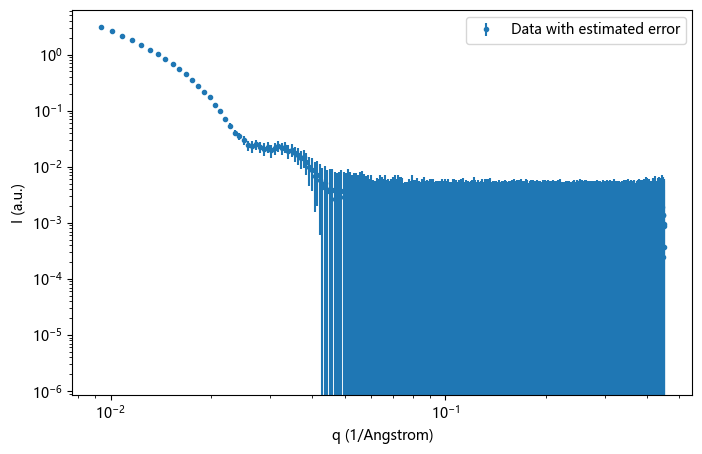

In [81]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,5))
plt.errorbar(q, I, yerr=sigma_I, fmt='o', markersize=3, label='Data with estimated error')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('q (1/Angstrom)')
plt.ylabel('I (a.u.)')
plt.legend()

In [82]:
# export q, I, sigma_I to dat file in Experiment_SAXS_data folder
data = np.vstack([q, I, sigma_I]).T
np.savetxt("Experiment_SAXS_data/real_nano_HR.dat", data, header="q\tI\tsigma_I")
plt.show()

In [ ]:
from utils.load_SAXS_data import load_xy_any

data = load_xy_any("Experiment_SAXS_data/real_nano_HR.dat")

# transfer to q and I arrays
q = data.q
I = data.I

{'path': 'd:\\PythonCode\\gisaxs_gui\\Experiment_SAXS_data\\real_nano_HR.dat', 'rows_total': 594, 'data_start_line': 2, 'delimiter': 'whitespace', 'bad_lines': 0, 'has_error': True}
